In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Schl&ouml;gl Model 

$$
B_1 + 2X \xrightleftharpoons[c_2]{c_1} 3X \\[10pt]
B_2 \xrightleftharpoons[c_4]{c_3} X
$$

In [2]:
# Initialize Generator object
rng = np.random.default_rng(seed=0)

In [3]:
def performSSA(t0 : float, tf : float, X0 : float, N1 = 1e5, N2 = 2e5,
               c1 = 3e-7, c2 = 1e-4, c3 = 1e-3, c4 = 3.5) -> pd.Series:
    """Perform a Stochastic Simulation Algorithm.
    
    Chooses a time to next event according to an exponential distribution. Consequently chooses whicch reaction
    takes place according to their relative probabilities. Updates the system state after every such calculation.

    Parameters
    ----------
    t0 : float
        The starting time of the simulation.
    tf : float
        The end time of the simulation.
    X0 : float
        The initial X molecule number.
    N1 : float
        Number of B1 molecules. Assumed constant in the simulation. Default value is 1e5.
    N2 : float
        Number of B2 molecules. Assumed constant in the simulation. Default value is 2e5.
    c1 : float
        Reaction rate 1. Default 3e-7.
    c2 : float
        Reaction rate 2. Default is 1e-4.
    c3 : float
        Reaction rate 3. Default is 1e-3.
    c4 : float
        Reaction rate 4. Default is 3.5.
    
    Returns
    -------
    out : pandas Series
        Returns a pandas Series object containing state of system (i.e. number of X molecules) at given time.
        Index of a particular state is the time in which the system attained that state.
    """
    t = t0
    X = X0
    tx = {t0 : X0}  # Dictionary {t : X} containing time and state of system at that time
    
    while t < tf:
        # Calculate transition rates
        a1 = c1 * N1 * 0.5*X*(X-1)
        a2 = c2 * X*(X-1)*(X-2)/6
        a3 = c3 * N2
        a4 = c4 * X
        a = [a1, a2, a3, a4]
        a0 = sum(a)
        tproc = rng.exponential(scale=1/a0)  # Choose time to next event using exponentially distributed random variable
        t += tproc
        # Choose which event happens
        r2 = rng.uniform(low=0, high=1)
        for i in range(len(a)):
            if r2 < sum(a[0:i+1])/a0:
                proc_index = i
                break

        # Update state
        if proc_index == 0:
            X = X + 1
        elif proc_index == 1:
            X = X - 1
        elif proc_index == 2:
            X = X + 1
        elif proc_index == 3:
            X = X - 1

        tx[t] = X

    return pd.Series(tx)

Prethodna ćelija definira funkciju `performSSA` koja izvršava Gillespiejev SSA (*Stochastic Simulation Algorithm*) algoritam. Funkcija najprije računa konstante prijelaza $a_1, a_2, a_3, a_4$ koje su dane izrazima
$$
\begin{gather*}
a_1 = c_1  N_1 \frac{X\left(X-1\right)}{2}\\[10pt]
a_2 = c_2 \frac{X\left(X-1\right)\left(X-2\right)}{6}\\[10pt]
a_3 = c_3 N_2\\[10pt]
a_4 = c_4 X
\end{gather*}
$$
Ukupna stopa prijelaza je $a_0 = \sum_{i=1}^4 a_i$. Nasumično biramo vrijeme do sljedećeg prijelaza na temelju eksponencijalne distribucije
$$
f(t, \alpha_0) = \alpha_0 \exp\left[-\alpha_0 \left(t-t_0\right)\right]
$$
Jednom kad smo odabrali nasumično vrijeme do idućeg prijelaza, biramo koja će se reakcija dogoditi. To radimo tako da generiramo uniformno raspodijeljen slučajni broj $r_2$ te tražimo minimalni $m$ za koji vrijedi
$$
r_2 < \sum_{i=1}^m a_i
$$
Preostaje još ažurirati stanje sustava ovisno o odabranoj reakciji.

In [4]:
# Parameters
N1 = 1e5  # B1 number
N2 = 2e5  # B2 number

c1 = 3e-7
c2 = 1e-4
c3 = 1e-3
c4 = 3.5

c = [c1, c2, c3, c4]

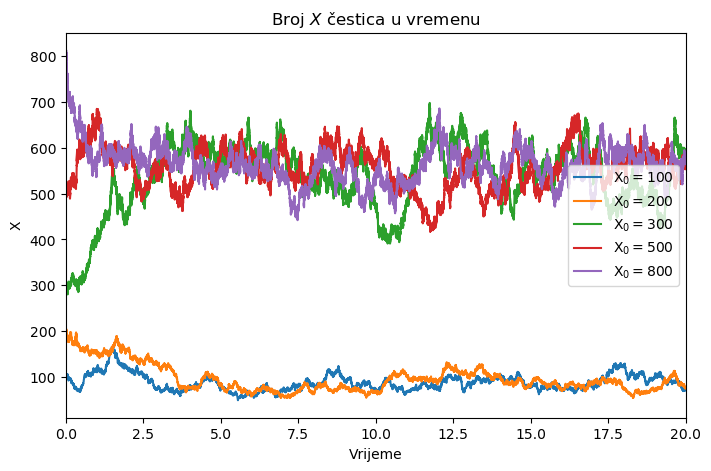

In [5]:
t0 = 0  # Initial time
tf = 20  # Final time
X0_vals = [100, 200, 300, 500, 800]  # Initial states

fig1, ax1 = plt.subplots(figsize=(8, 5))

for X0 in X0_vals:
    tx = performSSA(t0, tf, X0)
    ax1.plot(tx, label=f"$\mathrm{{X_0}} = {X0}$")

ax1.set_title("Broj $X$ čestica u vremenu")
ax1.set_xlabel("Vrijeme")
ax1.set_ylabel("$\mathrm{X}$")
ax1.set_xlim(t0, tf)
ax1.legend(loc="right")
plt.show()

Gornji graf prikazuje evoluciju sistema (tj. broj X jedinki) u vremenu. Početno vrijeme je $t_0 = 0$, a konačno $t_f = 20$. Krivulje prikazuju evoluciju za pet početnih vrijednosti broja X molekula: $X_0 = [100, 200, 300, 500, 800]$. Uočava se bistabilnost sustava - postoje dvije vrijednosti broja X molekula za koje je sustav u ravnoteži. 

In [6]:
# Evolution from X0 = 250
values = {}  # Dictionary to hold pd.Series
t0_250 = 0
tf_250 = 50
for i in range(7):
    values[i] = performSSA(t0_250, tf_250, 250)


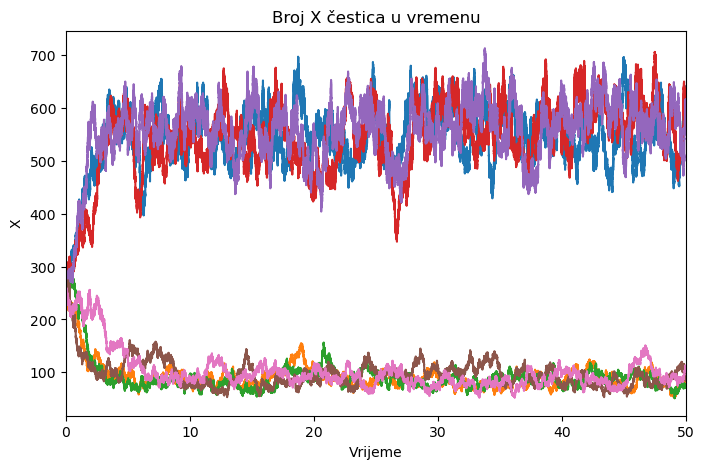

In [7]:
# Plot time evolution for X0 = 250
fig2, ax2 = plt.subplots(1, 1, figsize=(8, 5))
for i in range(len(values)):
    ax2.plot(values[i], c=f"C{i}")

ax2.set_title("Broj X čestica u vremenu")
ax2.set_xlabel("Vrijeme")
ax2.set_ylabel("$\mathrm{X}$")
ax2.set_xlim(t0_250, tf_250)
plt.show()

Graf u ćeliji iznad prikazuje sedam evolucija sustava s početnim brojem molekula $x_0 = 250$. Nasumična priroda procesa uzrokuje evoluciju procesa s istim početnim uvjetima prema različitim vrijednostima (dva stabilna stanja). Početno vrijeme $t_0 = 0$, konačno $t_f = 50$.

In [8]:
# Histogram of final X values for 1000 tries
# Initial X values distributed uniformly over [1, 1000]
N_tries = 1000
t0_hist = 0
tf_hist = 10

X0_for_hist = np.linspace(1, 1000, N_tries)
results = []

for X0 in X0_for_hist:
    results.append(performSSA(t0_hist, tf_hist, X0))

In [9]:
# Get final X value from every pd.Series
finalX = np.array([results[i].iloc[-1] for i in range(len(results))])

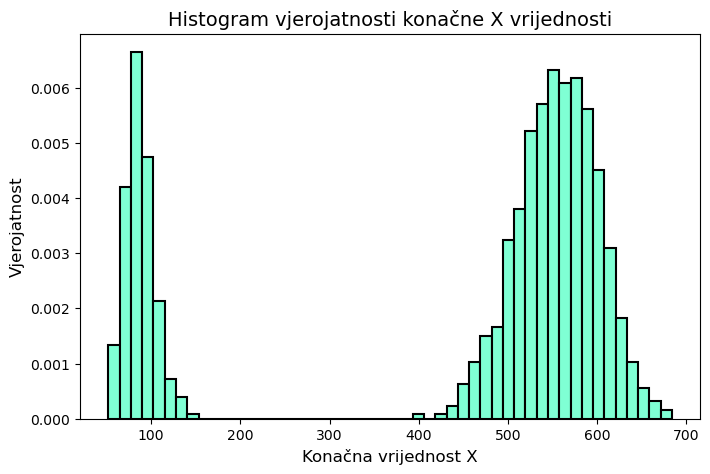

In [10]:
# Plot histogram of final X values
fig3, ax3 = plt.subplots(1, 1, figsize=(8, 5))

ax3.hist(finalX, bins=50, density=True, color="aquamarine", alpha=1, edgecolor="k", lw=1.5)
ax3.set_title("Histogram vjerojatnosti konačne X vrijednosti", fontsize=14)
ax3.set_xlabel("Konačna vrijednost X", fontsize=12)
ax3.set_ylabel("Vjerojatnost", fontsize=12)
plt.show()

Gornji histogram prikazuje konačnu vrijednost $X$ sustava za $t_0 = 0, t_f = 10$. Dobiven je simulacijom sustava za 1000 početnih vrijednosti $X_0$ od 1 do 1000 u koracima po 1. Uočavaju se dva stabilna stanja, jedno za $X \approx 100$, drugo za $X \approx 550$. Više vrijednosti $X$ imaju veću dispreziju zbog toga što konstante prijelaza rastu s $X$ na različite načine.

In [11]:
# Histogram of final X values
# Initial values choes uniformly in interval [200, 300), 1000 samples
t0_unif = 0
tf_unif = 10
X0_unif = rng.uniform(low=200, high=300, size=1000)

results_unif = []
for X0 in X0_unif:
    results_unif.append(performSSA(t0_unif, tf_unif, X0))

In [12]:
# Get final X for every pd.Series
finalX_unif = np.array([results_unif[i].iloc[-1] for i in range(len(results_unif))])

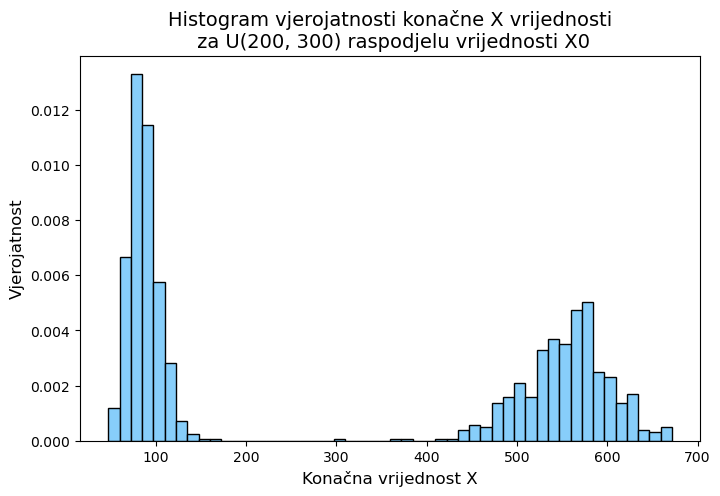

In [13]:
# Plot histogram of final X values
fig4, ax4 = plt.subplots(1, 1, figsize=(8, 5))

ax4.hist(finalX_unif, bins=50, density=True, color="lightskyblue", edgecolor="k", lw=1.0, alpha=1)
ax4.set_title("Histogram vjerojatnosti konačne X vrijednosti\n za U(200, 300) raspodjelu vrijednosti X0", fontsize=14)
ax4.set_xlabel("Konačna vrijednost X", fontsize=12)
ax4.set_ylabel("Vjerojatnost", fontsize=12)
plt.show()

Gornji histogram prikazuje konačnu $X$ vrijednost sustava za 1000 simulacija. Početni $X_0$ nasumično je odabran pomoću uniformne raspodjele na intervalu $[200, 300\rangle$. Početno vrijeme $t_0 = 0$, konačno $t_f = 10$.